## The formula I construct

$$\frac{2}{T}\sum_{t=1}^{\frac{T}{2}}[(x_{2t} - x_{2t-2}) * (y_{2t+1} - y_{2t-1})] * \sqrt{2}$$

## Let's read the dataset first

In [444]:
import pandas_datareader.data as web
import datetime as dt

df_tencent = web.DataReader('0700.hk', 'yahoo', dt.date(2015, 1, 1), dt.date(2020, 12, 31))
df_tencent = df_tencent['Adj Close']
df_tencent

Date
2015-01-02    111.096741
2015-01-05    111.786163
2015-01-06    118.188011
2015-01-07    122.521576
2015-01-08    125.377777
                 ...    
2020-12-24    557.500000
2020-12-28    519.000000
2020-12-29    530.500000
2020-12-30    559.500000
2020-12-31    566.000000
Name: Adj Close, Length: 1481, dtype: float64

In [445]:
df_google = web.DataReader('GOOG', 'yahoo', dt.date(2015, 1, 1), dt.date(2020, 12, 31))
df_google = df_google['Adj Close']
df_google

Date
2014-12-31     524.958740
2015-01-02     523.373108
2015-01-05     512.463013
2015-01-06     500.585632
2015-01-07     499.727997
                 ...     
2020-12-24    1738.849976
2020-12-28    1776.089966
2020-12-29    1758.719971
2020-12-30    1739.520020
2020-12-31    1751.880005
Name: Adj Close, Length: 1512, dtype: float64

In [446]:
import pandas as pd

df = pd.merge(df_tencent, df_google, on="Date")
df.columns = ['tencent', 'google']
df

,tencent,google
Date,,
2015-01-02,111.096741,523.373108
2015-01-05,111.786163,512.463013
2015-01-06,118.188011,500.585632
2015-01-07,122.521576,499.727997
2015-01-08,125.377777,501.303680
...,...,...
2020-12-24,557.500000,1738.849976
2020-12-28,519.000000,1776.089966
2020-12-29,530.500000,1758.719971


## Visualize the dataset, it appears that Tencent and Google are highly correlated

[]

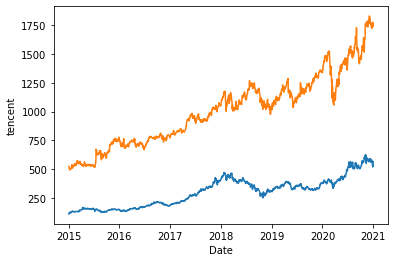

In [447]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.lineplot(x=df.index, y=df['tencent'])
sns.lineplot(x=df.index, y=df['google'])

plt.plot()

## Could Tencent and Google be a cointegrated pair?
While it is not quite related to the original question, let's do it, just for fun!

In [448]:
from statsmodels.tsa.stattools import coint

coint_t, p_value, crit_value = coint(df['tencent'], df['google'])
p_value

0.1408485616865035

If we just test the existence, the answer appears to be no...

However, we can make one step further...

In [449]:
import statsmodels.formula.api as smf

df_train2 = pd.DataFrame()
df_train2['X'] = df['tencent']
df_train2['y'] = df['google']
model = smf.ols(formula = 'y ~ X',
                data = df_train2).fit()
# This formula is given as domain knowledge
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     9612.
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        01:08:43   Log-Likelihood:                -8865.6
No. Observations:                1446   AIC:                         1.774e+04
Df Residuals:                    1444   BIC:                         1.775e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    323.4377      7.584     42.645      0.000     308.560     338.315
X              2.2850      0.023     98.041      0.000       2.239       2.331
==============================================================================
Omnibus:                        3.890   Durbin-Watson:                   0.042
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                3.923
Skew:                          -0.111   Prob(JB):                        0.141
Kurtosis:                       2.875   Cond. No.                         843.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

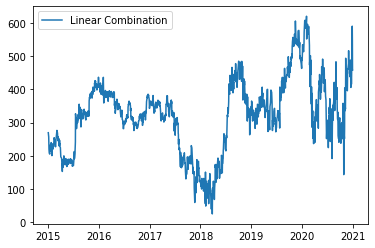

In [450]:
df['lc'] = -2.2850 * df['tencent'] + df['google']
plt.plot(df.index, df['lc'])
plt.legend(['Linear Combination']);

According to the ADF test, Tencent and Google **are** cointegrated! We may construct a statistical arbitrage
strategy! But now, let's get back to the very original question first...

In [451]:
from statsmodels.tsa.stattools import adfuller
p_value = adfuller(df['lc'])[1]
p_value

0.04402758018581471

## If I get you right, we can standardize the data to make it simpler

In [452]:
df['tencent'] = (df['tencent'] - df['tencent'].mean()) / df['tencent'].std()
df['google'] = (df['google'] - df['google'].mean()) / df['google'].std()
df['tencent']

Date
2015-01-02   -1.504074
2015-01-05   -1.498590
2015-01-06   -1.447665
2015-01-07   -1.413193
2015-01-08   -1.390473
                ...   
2020-12-24    2.046937
2020-12-28    1.740680
2020-12-29    1.832159
2020-12-30    2.062846
2020-12-31    2.114552
Name: tencent, Length: 1446, dtype: float64

In [453]:
df['google'].var()

0.9999999999999997

## First attempt: the naive way

In [454]:
df['tencent'].corr(df['google'])

0.932412372940946

## Second attempt: the way I proposed.
Seems the results are almost the same as the naive approach

In [455]:
df_tencent_sma = df['tencent'].rolling(window=20).mean().iloc[20:]
df_google_sma = df['google'].rolling(window=20).mean().iloc[20:]
df_google_sma.corr(df_tencent_sma)

0.9338380273292184

In [456]:
df_tencent_sma = df['tencent'].rolling(window=60).mean().iloc[60:]
df_google_sma = df['google'].rolling(window=60).mean().iloc[60:]
df_google_sma.corr(df_tencent_sma)

0.9339385571181312

## Third attempt: the sophisticated approach
### Step 1: Remove half of data from Tencent from row 0

In [457]:
df_tencent = df['tencent']
df_tencent = df_tencent.iloc[::2]
df_tencent

Date
2015-01-02   -1.504074
2015-01-06   -1.447665
2015-01-08   -1.390473
2015-01-12   -1.392040
2015-01-14   -1.400658
                ...   
2020-12-17    2.249782
2020-12-21    2.162280
2020-12-23    2.154325
2020-12-28    1.740680
2020-12-30    2.062846
Name: tencent, Length: 723, dtype: float64

### Step 2: Remove half of data from Google from row 1

In [458]:
df_google = df['google']
df_google = df_google.iloc[1:]
df_google = df_google.iloc[::2]
df_google

Date
2015-01-05   -1.612856
2015-01-07   -1.654194
2015-01-09   -1.670153
2015-01-13   -1.670121
2015-01-15   -1.651961
                ...   
2020-12-18    2.342534
2020-12-22    2.318157
2020-12-24    2.367983
2020-12-29    2.432480
2020-12-31    2.410278
Name: google, Length: 723, dtype: float64

### Step 3: Calculate $(x_{2t} - x_{2t-2})$ and $(y_{2t+1} - y_{2t-1})$ respectively

In [459]:
df_tencent.diff()
df_tencent

Date
2015-01-02   -1.504074
2015-01-06   -1.447665
2015-01-08   -1.390473
2015-01-12   -1.392040
2015-01-14   -1.400658
                ...   
2020-12-17    2.249782
2020-12-21    2.162280
2020-12-23    2.154325
2020-12-28    1.740680
2020-12-30    2.062846
Name: tencent, Length: 723, dtype: float64

In [460]:
df_google.diff()
df_google

Date
2015-01-05   -1.612856
2015-01-07   -1.654194
2015-01-09   -1.670153
2015-01-13   -1.670121
2015-01-15   -1.651961
                ...   
2020-12-18    2.342534
2020-12-22    2.318157
2020-12-24    2.367983
2020-12-29    2.432480
2020-12-31    2.410278
Name: google, Length: 723, dtype: float64

In [461]:
df_tencent.reset_index(drop=True, inplace=True)
df_google.reset_index(drop=True, inplace=True)
df_google

0     -1.612856
1     -1.654194
2     -1.670153
3     -1.670121
4     -1.651961
         ...   
718    2.342534
719    2.318157
720    2.367983
721    2.432480
722    2.410278
Name: google, Length: 723, dtype: float64

### Step 4: Calculate $(x_{2t} - x_{2t-2}) * (y_{2t+1} - y_{2t-1})$

In [462]:
df_res = df_tencent * df_google

### Step 5: Result
If I do **not** multiply the mean() by $\sqrt{2}$, it is pretty close to the first two attempts.

In [463]:
df_res.mean()

0.9309268419354831

If I do, then the result will be greater than one, which, by the definition of Pearson's correlation coefficient,
is impossible

In [464]:
df_res.mean() * 2 ** 0.5

1.316529365442315